## StarGAN に進む前に ACGAN を学ぶ
Reference: https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/acgan/acgan.py

In [1]:
import os
import datetime
import numpy as np
import pandas as pd

In [2]:
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [3]:
#from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

In [4]:
import torch.nn as nn
#import torch.nn.functional as F
import torch

In [5]:
#torch.__version__

In [6]:
DATA_DIR_PATH = '/content/drive/My Drive/project/ML/pytorch-gan/data'

OUTPUT_DIR_PATH = os.path.join(DATA_DIR_PATH, '08_out')

In [7]:
os.makedirs(os.path.join(OUTPUT_DIR_PATH, 'images'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR_PATH, 'saved_models'), exist_ok=True)

In [8]:
cuda = True if torch.cuda.is_available() else False

In [9]:
def weights_init_normal(m):
    classname = m.__class__.__name__

    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [10]:
class Generator(nn.Module):
    def __init__(self, img_size=32, channels=1, n_classes=10, latent_dim=100):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, latent_dim)

        self.init_size = img_size // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        gen_input = torch.mul(self.label_emb(labels), noise)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [11]:
class Discriminator(nn.Module):
    def __init__(self, img_size=32, channels=1, n_classes=10):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            """Returns layers of each discriminator block"""
            block = [
                nn.Conv2d(in_filters, out_filters, 3, 2, 1),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout2d(0.25)
            ]

            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, n_classes), nn.Softmax())

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)

        return validity, label

In [12]:
class ACGAN:
    def __init__(self, data_loader, n_classes=10, latent_dim=100):
        self.history = pd.DataFrame({}, columns=[
            'epoch', 'batche_i',
            'loss_D', 'acc', 'loss_G',
            'elapsed_time'
        ])

        self.data_loader = data_loader

        self.img_save_dir = os.path.join(OUTPUT_DIR_PATH, 'images')
        self.model_save_dir = os.path.join(OUTPUT_DIR_PATH, 'saved_models')
        self.generator_name = 'generator_model'

        self.train_cnt = 0

        self.n_classes = n_classes
        self.latent_dim = latent_dim

        # Loss functions
        self.adversarial_loss = torch.nn.BCELoss()
        self.auxiliary_loss = torch.nn.CrossEntropyLoss()

        # Initialize generator and discriminator
        self.generator = Generator()
        self.discriminator = Discriminator()

        if cuda:
            self.generator.cuda()
            self.discriminator.cuda()
            self.adversarial_loss.cuda()
            self.auxiliary_loss.cuda()

        # Initialize weights
        self.generator.apply(weights_init_normal)
        self.discriminator.apply(weights_init_normal)

        self.lr = 0.0002
        self.b1 = 0.5
        self.b2 = 0.999

        # Optimizers
        self.optimizer_G = torch.optim.Adam(self.generator.parameters(), lr=self.lr, betas=(self.b1, self.b2))
        self.optimizer_D = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=(self.b1, self.b2))

        self.FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
        self.LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

    def train(self, n_epochs, sample_interval=-1):
        self.train_cnt += 1

        print(datetime.datetime.now().isoformat(), 'Start', self.train_cnt)

        start_time = datetime.datetime.now()

        step_cnt = 1

        for epoch in range(1, n_epochs+1):

            for i, (imgs, labels) in enumerate(self.data_loader, 1):
                batch_size = imgs.shape[0]

                # Adversarial ground truths
                valid = Variable(self.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
                fake = Variable(self.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

                # Configure input
                real_imgs = Variable(imgs.type(self.FloatTensor))
                labels = Variable(labels.type(self.LongTensor))

                # Train Generator
                self.optimizer_G.zero_grad()

                # Sample noise and labels as generator input
                z = Variable(self.FloatTensor(np.random.normal(0, 1, (batch_size, self.latent_dim))))
                gen_labels = Variable(self.LongTensor(np.random.randint(0, self.n_classes, batch_size)))

                # Generate a batch of images
                gen_imgs = self.generator(z, gen_labels)

                # Loss measures generator's ability to fool the discriminator
                validity, pred_label = self.discriminator(gen_imgs)
                g_loss = 0.5 * (self.adversarial_loss(validity, valid) + self.auxiliary_loss(pred_label, gen_labels))

                g_loss.backward()
                self.optimizer_G.step()

                # Train Discriminator
                self.optimizer_D.zero_grad()

                # Loss for real images
                real_pred, real_aux = self.discriminator(real_imgs)
                d_real_loss = (self.adversarial_loss(real_pred, valid) + self.auxiliary_loss(real_aux, labels)) / 2

                # Loss for fake images
                fake_pred, fake_aux = self.discriminator(gen_imgs.detach())
                d_fake_loss = (self.adversarial_loss(fake_pred, fake) + self.auxiliary_loss(fake_aux, gen_labels)) / 2

                # Total discriminator loss
                d_loss = (d_real_loss + d_fake_loss) / 2

                # Calculate discriminator accuracy
                pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
                gt = np.concatenate([labels.data.cpu().numpy(), gen_labels.data.cpu().numpy()], axis=0)
                d_acc = np.mean(np.argmax(pred, axis=1) == gt)

                d_loss.backward()
                self.optimizer_D.step()

                # Log Progress
                batches_done = epoch * len(self.data_loader) + i
                elapsed_time = datetime.datetime.now() - start_time

                self.history = self.history.append({
                    'epoch': epoch,
                    'batch_i': i,
                    'loss_D': d_loss.item(),
                    'acc': 100 * d_acc,
                    'loss_G': g_loss.item(),
                    'elapsed_time': elapsed_time
                }, ignore_index=True)

                if sample_interval > 0 and step_cnt % sample_interval == 0:
                    print(
                        '[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %d%%] [G loss: %f] %s'
                        % (
                            epoch,
                            n_epochs,
                            i,
                            len(self.data_loader),
                            d_loss.item(),
                            100 * d_acc,
                            g_loss.item(),
                            elapsed_time
                        )
                    )
                    # sys.stdout.write()

                    self.sample_images(epoch, i, n_row=10)

                step_cnt += 1

        print(datetime.datetime.now().isoformat(), 'End')

    def sample_images(self, epoch, batch_i, n_row=5):
        """Saves a grid of generated digits ranging from 0 to n_classes"""
        # Sample noise
        z = Variable(self.FloatTensor(np.random.normal(0, 1, (n_row ** 2, self.latent_dim))))

        # Get labels ranging from 0 to n_classes for n rows
        labels = np.array([num for _ in range(n_row) for num in range(n_row)])
        labels = Variable(self.LongTensor(labels))
        gen_imgs = self.generator(z, labels)

        file_name = os.path.join(self.img_save_dir, '{}_{}_{}.png'.format(self.train_cnt, epoch, batch_i))
        save_image(gen_imgs.data, file_name, nrow=n_row, normalize=True)

    def plot_hisotry(self, columns=[]):
        if len(columns) == 0:
            columns = ['loss_D', 'loss_G']
        self.history[columns].plot()

    def save_models(self, file_suffix=None):
        self.save_state_dict(self.generator, self.generator_name, file_suffix)

    def save_state_dict(self, model, model_name, file_suffix=None):
        file_path = os.path.join(self.model_save_dir, self._create_model_file_name(model_name, file_suffix))
        torch.save(model.state_dict(), file_path)
        print('Model saved.', model_name)

    def _create_model_file_name(self, model_name, suffix=None):
        processor = 'gpu' if cuda else 'cpu'

        if suffix:
            return '{}_{}_{}.pth'.format(model_name, processor, suffix)
        else:
            return '{}_{}.pth'.format(model_name, processor)

In [13]:
img_size = 32
batch_size = 64

In [14]:
# Configure data loader
MNIST_DATA_DIR_PATH = os.path.join(DATA_DIR_PATH, 'mnist')

dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        MNIST_DATA_DIR_PATH,
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

2020-10-12T11:31:24.541065 Start 1


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[Epoch 1/1] [Batch 10/938] [D loss: 1.497760, acc: 17%] [G loss: 1.491754] 0:00:00.730852
[Epoch 1/1] [Batch 20/938] [D loss: 1.497639, acc: 10%] [G loss: 1.493344] 0:00:02.801778
[Epoch 1/1] [Batch 30/938] [D loss: 1.497668, acc: 8%] [G loss: 1.494828] 0:00:03.975863
[Epoch 1/1] [Batch 40/938] [D loss: 1.494399, acc: 11%] [G loss: 1.502760] 0:00:05.111170
[Epoch 1/1] [Batch 50/938] [D loss: 1.491671, acc: 11%] [G loss: 1.491633] 0:00:06.244120
[Epoch 1/1] [Batch 60/938] [D loss: 1.497403, acc: 15%] [G loss: 1.470512] 0:00:06.693549
[Epoch 1/1] [Batch 70/938] [D loss: 1.497064, acc: 12%] [G loss: 1.500147] 0:00:07.149513
[Epoch 1/1] [Batch 80/938] [D loss: 1.498093, acc: 11%] [G loss: 1.497493] 0:00:07.613219
[Epoch 1/1] [Batch 90/938] [D loss: 1.499088, acc: 9%] [G loss: 1.509184] 0:00:08.071657
[Epoch 1/1] [Batch 100/938] [D loss: 1.496752, acc: 11%] [G loss: 1.491599] 0:00:08.513044
[Epoch 1/1] [Batch 110/938] [D loss: 1.497101, acc: 14%] [G loss: 1.509894] 0:00:08.984413
[Epoch 1/1

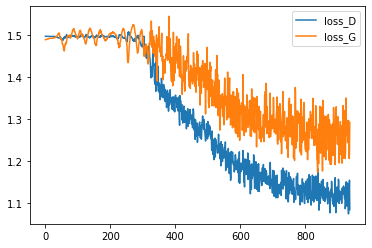

In [15]:
n_epochs = 1
sample_interval = 10

gan = ACGAN(dataloader)
gan.train(n_epochs, sample_interval)

gan.plot_hisotry()

In [16]:
gan.save_models()

Model saved. generator_model
